# 1. Setup

In [ ]:
%%capture
!pip install umap-learn
!pip install datasets

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%cd "gdrive/My Drive/"

In [1]:
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
from IPython import display
from pathlib import Path
import os
from enum import Enum
from einops.layers.torch import Rearrange
from typing import Tuple, List, Dict

# import standard PyTorch modules
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F

import umap
import datasets
import zipfile
import re
import albumentations

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
print("Running on torch.__version__ = ", torch.__version__)

torch.backends.cudnn.deterministic = True

# utils
from tqdm.notebook import tqdm
from collections import Counter

torch.cuda.empty_cache()

Running on torch.__version__ =  2.4.1+cu121


# 2. Dataset

In [2]:
TRAIN_DATASET_DIR = "./dataset/neutral_trim/train/"
VAL_DATASET_DIR = "./dataset/neutral_trim/val/"
TEST_DATASET_DIR = "./dataset/neutral_trim/test/"

## 2.1. Preview a sample of PGM

In [3]:
data = np.load(TRAIN_DATASET_DIR+"PGM_neutral_train_10.npz")
images = data["image"].reshape(16, 160, 160)
ans = data["target"]

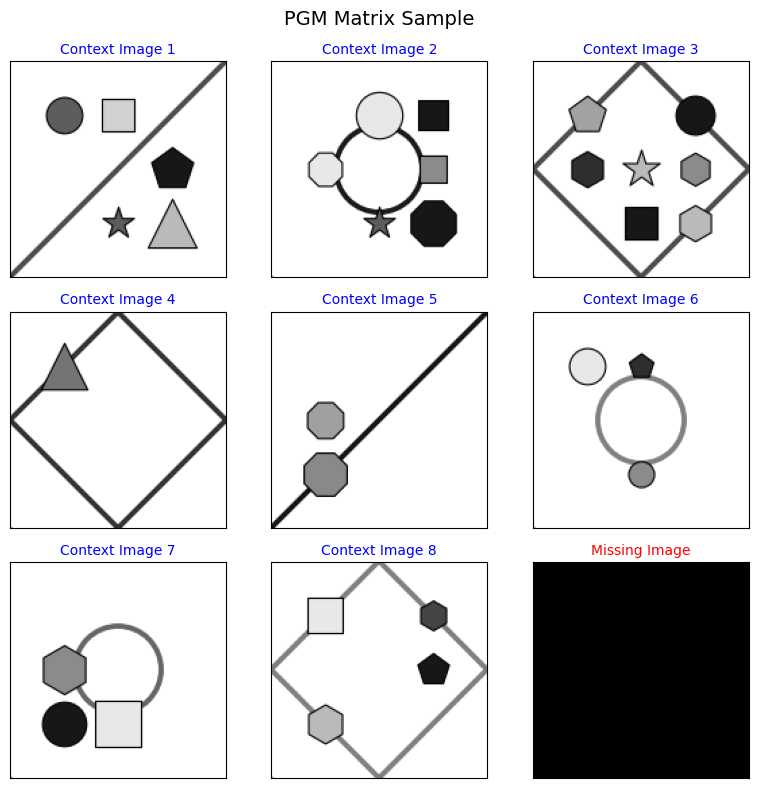

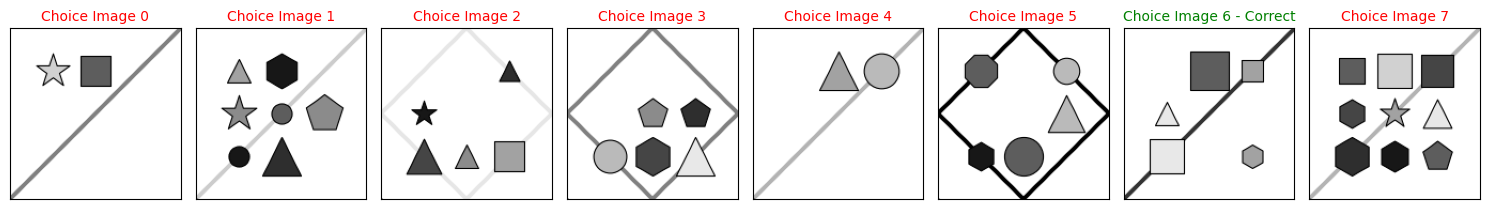

In [4]:
def plot_matrices(images, ans):

    # Add a new image at the 8th index (You can modify 'new_image' as needed)
    missing_image = np.zeros((160, 160))  # Example new image (randomly generated here)
    images_to_plot = np.append(images[:8], [missing_image], axis=0)  # Insert the new image at 8th position
    images_to_plot = np.append(images_to_plot, images[8:], axis=0)

    # Plot first 8 images in a 4x2 grid with the first heading
    fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
    fig1.suptitle("PGM Matrix Sample", fontsize=14)


    for i, ax in enumerate(axes1.flat):
        ax.imshow(images_to_plot[i], cmap='gray')
        if i == 8:
            ax.set_title("Missing Image", fontsize=10, color="red")
        else:
          ax.set_title(f"Context Image {i+1}", fontsize=10, color="blue")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()

    # Plot first 8 images in a 4x2 grid with the first heading
    fig2, axes2 = plt.subplots(1, 8, figsize=(15, 15))

    for i, ax in enumerate(axes2.flat):
        ax.imshow(images_to_plot[i+9], cmap='gray')
        if i == ans:
            ax.set_title(f"Choice Image {i} - Correct", fontsize=10, color="green")
        else:
            ax.set_title(f"Choice Image {i}", fontsize=10, color="red")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

plot_matrices(images, ans)

## 2.2. PGM Dataset Class

In [5]:
class PgmDataset(Dataset):
    FILEPATH_PATTERN = re.compile(r"PGM_([\w.]+)_(\w+)_(\d+).npz")

    def __init__(
            self,
            # transform = None,
            data_dir: str = '.',
            double_downscale_images: bool = False):
        super().__init__()
        self.filenames = self._list_filenames(data_dir)
        self.reshape_images = True
        self.double_downscale_images = double_downscale_images

    def __len__(self) -> int:
        return len(self.filenames)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        data = np.load(self.filenames[idx])
        images, target, meta_matrix, meta_target = data['image'], data['target'], data['relation_structure_encoded'], data['meta_target']
        if self.reshape_images:
            h, w, n = images.shape  # n = number of context/choice images (which is 8)
            images = np.ascontiguousarray(images.reshape(n, h, w))
        if self.double_downscale_images:
            images = images[:, ::2, ::2]
        images = images.astype('float32') / 255.0
        images = self._to_tensor(images)
        context_images = images[:8]
        choice_images = images[8:]
        target = torch.tensor(target)
        meta_matrix = torch.tensor(meta_matrix)
        meta_target = torch.tensor(meta_target)
        return {'context_images': context_images,'choice_images': choice_images, 'target': target, 'meta_matrix':meta_matrix, 'meta_target': meta_target}

    @staticmethod
    def _to_tensor(images: np.array) -> torch.Tensor:
        return torch.tensor(images)

    def _list_filenames(self, data_dir: str):
        return [
            os.path.join(data_dir, f)
            for f in os.listdir(data_dir)
        ]


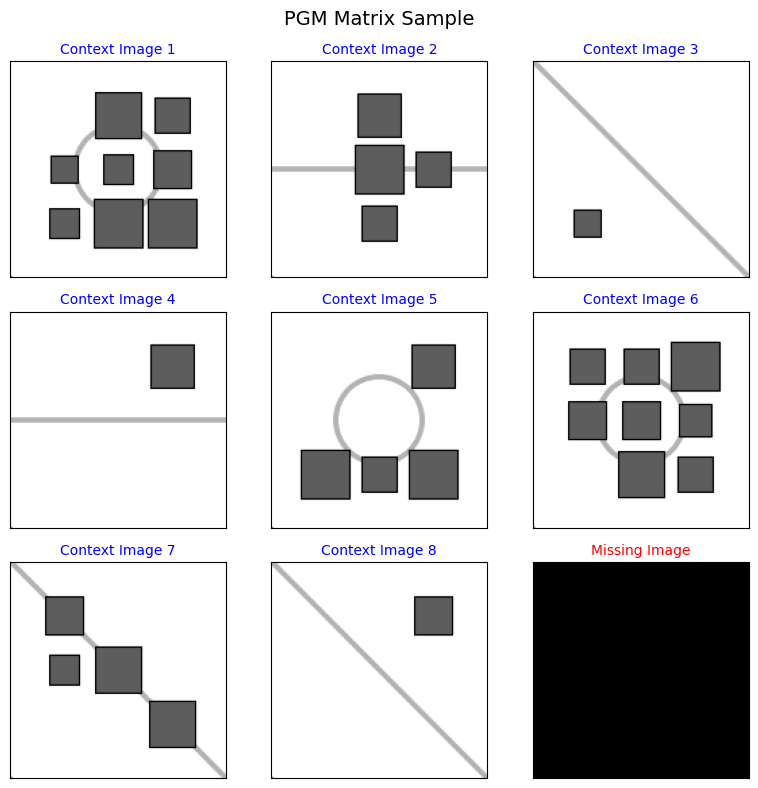

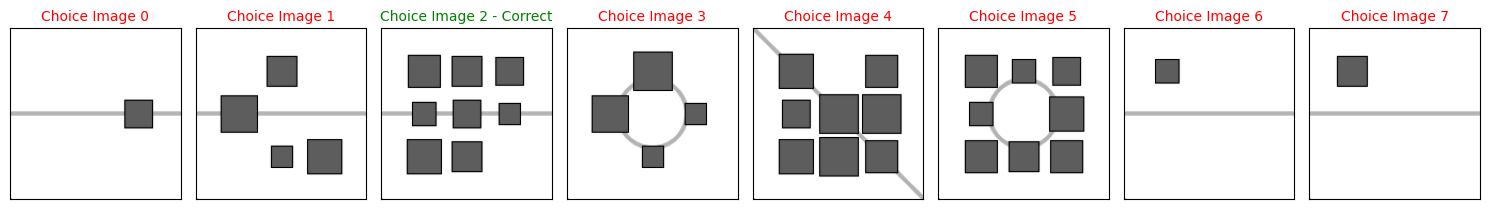

torch.Size([8, 160, 160])


In [6]:
# Create instances of the PgmDataset for Train, Val and Test
pgm_dataset_train = PgmDataset(
    data_dir=TRAIN_DATASET_DIR,
    double_downscale_images=False
)

pgm_dataset_val = PgmDataset(
    data_dir=VAL_DATASET_DIR,
    double_downscale_images=False
)

pgm_dataset_test = PgmDataset(
    data_dir=TEST_DATASET_DIR,
    double_downscale_images=False
)

# plot a sample from train dataset
sample = pgm_dataset_train[0]
context_images, choice_images, target, meta_matrix, meta_target = pgm_dataset_train[0]
images = np.append(sample['context_images'], sample['choice_images'], axis=0)
plot_matrices(images, sample['target'])

print(sample['context_images'].shape)

# 3. Vision Transformer Model

## 3.1. Helper Functions

In [7]:
# a function to move tensors from the CPU to the GPU and vice versa
def dict_to_device(orig, device):
    new = {}
    for k,v in orig.items():
        if isinstance(v, torch.Tensor):
            new[k] = v.to(device)
        elif isinstance(v, list):
            new[k] = [item.to(device) for item in v if isinstance(item, torch.Tensor)]
        else:
            new[k] = v  # If it's neither a tensor nor a list of tensors, leave it unchanged
    return new

## 3.2. Network Classes

### 3.2.1. Patch Embedding (Not Used)

In [8]:
class PatchEmbedding(nn.Module):
  def __init__(self, embed_dim: int, patch_size: int, num_patches: int, dropout: float, in_channels: int):
      super().__init__()
      self.patcher = nn.Sequential(
          # We use conv for doing the patching
          nn.Conv2d(
              in_channels=in_channels,
              out_channels=embed_dim,
              # if kernel_size = stride -> no overlap
              kernel_size=patch_size,
              stride=patch_size
          ),
          # Linear projection of Flattened Patches. We keep the batch and the channels (b,c,h,w)
          nn.Flatten(2))
      self.cls_token = nn.Parameter(torch.randn(size=(1, 1, embed_dim)), requires_grad=True)
      self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
      self.dropout = nn.Dropout(p=dropout)

  def forward(self, x: Tensor) -> Tensor:
      # Create a copy of the cls token for each of the elements of the BATCH
      cls_token = self.cls_token.expand(x.shape[0], -1, -1)
      # Create the patches
      x = self.patcher(x).permute(0, 2, 1)
      # Unify the position with the patches
      x = torch.cat([cls_token, x], dim=1)
      # Patch + Position Embedding
      x = self.position_embeddings + x
      x = self.dropout(x)
      return x

In [9]:
class PatchEmbeddingManual(nn.Module):
    def __init__(self, embed_dim: int, patch_size: int, num_images: int):
      super().__init__()
      self.embed_dim = embed_dim
      self.num_images = num_images
      self.patch_size = patch_size
      self.projection = nn.Linear(self.num_images * (self.patch_size ** 2), self.embed_dim)


    # Helper function for splitting an image tensor into multiple patches
    def img_patcher(self, img: Tensor, patch_size: int) -> Tensor:
      # Break-down the image in s1 x s2 patches and flatten them
      # Shape of the original input: [B_SIZE, NUM_CHOICE_IMAGES, NUM_CONTEXT_IMAGES+1, H, W]
      B, N_CHOICE, N_COMB, H, W = img.shape
      P = patch_size
      # [H', W'] = [H, W] // P
      img = img.reshape(B, N_CHOICE, N_COMB, H // P, P, W // P, P)  # Shape = [B, N_CHOICE, N_COMB, H', P, W', P]
      img = img.permute(0, 1, 3, 5, 2, 4, 6)  # Shape =  [B, N_CHOICE, H', W', N_COMB, P, P]
      img = img.flatten(2, 3)  # Shape = [B, N_CHOICE, H'*W', N_COMB, P, P]
      img = img.flatten(3, 5)  # Shape = [B, N_CHOICE, H'*W', N_COMB*P*P]

      return img


    def forward(self, x: Tensor) -> Tensor:
      x = self.img_patcher(x, patch_size=self.patch_size)  # Shape = [B, N_CHOICE, H'*W', N_COMB*P*P]
      x = self.projection(x)
      return x

In [10]:
class PatchEmbeddingManualv1(nn.Module):
    def __init__(self, embed_dim: int, patch_size: int):
        """
        Initializes the patch embedding module.
        Args:
        - embed_dim (int): Dimension of the patch embeddings.
        - patch_size (int): Size of each square patch (P).
        """
        super().__init__()
        self.embed_dim = embed_dim
        self.patch_size = patch_size
        self.projection = nn.Linear(patch_size * patch_size, embed_dim)

    def img_patcher(self, img: Tensor) -> Tensor:
        """
        Splits an image tensor into patches and flattens them.
        Args:
        - img (Tensor): Input image tensor of shape [BATCH_SIZE, NUM_IMAGES, H, W].
        Returns:
        - Tensor: Flattened patches of shape [BATCH_SIZE, NUM_IMAGES, N_PATCHES, PATCH_SIZE*PATCH_SIZE].
        """
        B, N_IMG, H, W = img.shape  # Batch size, number of images, height, and width
        P = self.patch_size


        # Reshape into patches
        img = img.reshape(B, N_IMG, H // P, P, W // P, P)  # Shape: [B, N_IMG, H', P, W', P]
        img = img.permute(0, 1, 2, 4, 3, 5)  # Shape: [B, N_IMG, H', W', P, P]
        img = img.flatten(2, 3)  # Shape: [B, N_IMG, N_PATCHES, P, P]
        img = img.flatten(-2, -1)  # Shape: [B, N_IMG, N_PATCHES, P*P]

        return img

    def forward(self, x: Tensor) -> Tensor:
        """
        Processes the input images into patch embeddings.
        Args:
        - x (Tensor): Input image tensor of shape [BATCH_SIZE, NUM_IMAGES, H, W].
        Returns:
        - Tensor: Patch embeddings of shape [BATCH_SIZE, NUM_IMAGES, N_PATCHES, EMBED_DIM].
        """
        x = self.img_patcher(x)  # Shape: [B, N_IMG, N_PATCHES, PATCH_SIZE*PATCH_SIZE]
        x = self.projection(x)  # Shape: [B, N_IMG, N_PATCHES, EMBED_DIM]
        return x

### 3.2.2. Static Positional Encoder (Not Used)

In [11]:
class PositionalEncoder(nn.Module):
    def __init__(self, embedding_dim: int, max_len: int, drop_out: float):
        super(PositionalEncoder, self).__init__()

        self.dropout = nn.Dropout(p=drop_out)

        pe = torch.zeros(max_len, embedding_dim)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        denominator = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-math.log(10000.0) / embedding_dim))

        pe[:, 0::2] = torch.sin(pos * denominator)
        pe[:, 1::2] = torch.cos(pos * denominator)

        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

### 3.2.3. ViT Encoder Layer

In [12]:
class VitEncoderLayer(nn.Module):
    def __init__(self, embedding_dim: int, num_heads: int, ff_dim: int, dropout: float):
        super(VitEncoderLayer, self).__init__()

        self.norm1 = nn.LayerNorm(embedding_dim)
        self.attention = nn.MultiheadAttention(embedding_dim, num_heads, dropout)
        self.dropout = nn.Dropout(dropout)
        self.mlp = MLP(embedding_dim, ff_dim, dropout)
        self.norm2 = nn.LayerNorm(embedding_dim)

    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        # x.shape (original) = [num_patches+1, batch_size, embed_dim]
        x = self.norm1(x)
        # attn_weights.shape = [batch_size, num_patches+1, num_patches+1]
        attn_out, attn_weights = self.attention(x, x, x)
        x = x + attn_out

        # Layer normalization after residual
        x = self.norm2(x)
        mlp_out = self.mlp(x)
        x = x + mlp_out  # Shape = [num_patches+1, batch_size, embed_dim]

        return x, attn_weights

### 3.2.4. ViT Encoder

In [13]:
class VitEncoder(nn.Module):
  def __init__(self, embed_dim: int, num_heads: int, num_layers: int, ff_dim: int, dropout: float = 0.1):
    super().__init__()
    self.vit_encoder_layers = nn.ModuleList([
        VitEncoderLayer(
            embed_dim,
            num_heads,
            ff_dim,
            dropout
        )
        for _ in range(num_layers)
    ])
    self.norm = nn.LayerNorm(embed_dim)

  def forward(self, x: Tensor) -> Tuple[Tensor, Tensor]:
    attention_weights = []  # Shape = [num_layers, batch_size, num_patches+1, num_patches+1]
    for layer in self.vit_encoder_layers:
      x, attention = layer(x)
      attention_weights.append(attention)
    out = self.norm(x)  # Shape = [num_patches+1, batch_size, embed_dim]
    return out, attention_weights

### 3.2.5. Multi-Layer Perceptrons

In [14]:
class MLP(nn.Module):
    def __init__(self, embed_dim: int, hidden_dim: int, dropout: float = .0):
      super().__init__()
      self.fc1 = nn.Linear(embed_dim, hidden_dim)
      self.activation = nn.GELU()
      self.fc2 = nn.Linear(hidden_dim, embed_dim)
      self.drop = nn.Dropout(dropout)

    def forward(self, x: Tensor) -> Tensor:
      x = self.fc1(x)
      x = self.activation(x)
      x = self.fc2(x)
      x = self.drop(x)
      return x

## 3.4. Network

In [ ]:
# Transformer attributes
BATCH_SIZE = 32
IMAGE_SIZE = 160
NUM_IMAGES = 8
EMBED_DIM = 512
PATCH_SIZE = 160
PATCH_NUM = (IMAGE_SIZE//PATCH_SIZE) ** 2
NUM_HEADS = 8
NUM_LAYERS = 10
FF_DIM = 1024

In [17]:
class ViT(nn.Module):
    def __init__(self):
        super(ViT, self).__init__()

        #self.embedding = nn.Linear(PATCH_SIZE * PATCH_SIZE, EMBED_DIM)
        self.embedding = nn.Conv2d(
          in_channels=1,
          out_channels=EMBED_DIM,  # Output embedding dimension
          kernel_size=PATCH_SIZE,  # Patch size as kernel size
          stride=PATCH_SIZE
        )
        self.cls_token = nn.Parameter(torch.randn(1, EMBED_DIM))
        self.positional_embedding = nn.Parameter(torch.randn(1, 1, EMBED_DIM))
        self.dropout = nn.Dropout(0.1)

        self.vit_encoder = VitEncoder(
            embed_dim=EMBED_DIM,
            num_heads=NUM_HEADS,
            num_layers=NUM_LAYERS,
            ff_dim=FF_DIM,
            dropout=0.1
        )
        self.score_head = nn.Sequential(
            nn.LayerNorm(EMBED_DIM),
            nn.Linear(EMBED_DIM, 128),
            nn.ReLU(),
            nn.Linear(128, EMBED_DIM),
            nn.ReLU(),
            nn.Linear(EMBED_DIM, 1)  # Output a single score per choice
        )

    def forward(self, input_dict: Dict[str, Tensor]) -> Dict[str, Tensor]:

        context_images = input_dict['context_images']  # Shape = [B_SIZE, NUM_CONTEXT_IMAGES, H, W]
        choice_images = input_dict['choice_images']  # Shape = [B_SIZE, NUM_CHOICE_IMAGES, H, W]

        B_SIZE = context_images.shape[0]  # Batch size
        N_CONTEXT = context_images.shape[1]  # Number of context images
        N_CHOICE = choice_images.shape[1]  # Number of choice images
        H, W = context_images.size(2), context_images.size(3)

        device = context_images.device  # Ensure same device as input images

        # Embed context images
        context_embeddings = torch.empty([B_SIZE, N_CONTEXT, EMBED_DIM]).to(device)
        for i in range(N_CONTEXT):
            context_image_batch = context_images[:, i, :, :].unsqueeze(1)  # Shape: [B_SIZE, 1, H, W]
            embedded_context = self.embedding(context_image_batch).squeeze()  # Shape: [B_SIZE, EMBED_DIM]
            #context_embeddings = torch.cat([context_embeddings, embedded_context.unsqueeze(1)], dim=1)
            context_embeddings[:, i] =  embedded_context

        # Expand class token for batch size and prepend
        batch_class_token = self.cls_token.expand(B_SIZE, -1, -1)  # Shape: [B_SIZE, 1, EMBED_DIM]
        context_embeddings = torch.cat([context_embeddings, batch_class_token], dim=1)  # Shape: [B_SIZE, N_CONTEXT + N_CHOICE + 1, EMBED_D  IM]

        #print(context_embeddings.shape)

        # Embed choice images
        combined_embeddings = torch.empty([B_SIZE, N_CHOICE, N_CONTEXT+1+1, EMBED_DIM]).to(device)
        for i in range(N_CHOICE):
            choice_image_batch = choice_images[:, i, :, :].unsqueeze(1)  # Shape: [B_SIZE, 1, H, W]
            embedded_choice = self.embedding(choice_image_batch).squeeze()  # Shape: [B_SIZE, EMBED_DIM]
            combined_embeddings[:, i] = torch.cat([context_embeddings, embedded_choice.unsqueeze(1)], dim=1)


        # Add positional encoding
        combined_embeddings += self.positional_embedding  # Shape: [B_SIZE, N_CONTEXT + N_CHOICE + 1, EMBED_DIM]

        # Transformer encoding
        x = torch.flatten(combined_embeddings, 0, 1)  # Reshape to [B_SIZE*N_CHOICE, N_PATCHES+1, EMBED_DIM]
        x = x.permute(1, 0, 2)  # Reshape to [N_PATCHES+1, B_SIZE*N_CHOICE, EMBED_DIM]
        x, _ = self.vit_encoder(x)
        x = x.permute(1, 0, 2)  # Reshape back to [B_SIZE*N_CHOICE, N_PATCHES+1, EMBED_DIM]
        x = x.view(B_SIZE, N_CHOICE, N_CHOICE+2 , EMBED_DIM)  # Reshape back to [B_SIZE, N_CHOICE, N_PATCHES+1, EMBED_DIM]

        # Mean pooling across all patches
        x = torch.mean(x, dim=1)

        # Compute the relationship score with the context embedding
        choice_scores = self.score_head(x)  # Shape = [B_SIZE, N_CHOICE, 1]
        choice_scores = torch.flatten(choice_scores, 1, 2)  # score.shape = [B_SIZE, N_CHOICE]

        return {'choice_scores': choice_scores}


# Training and Validation

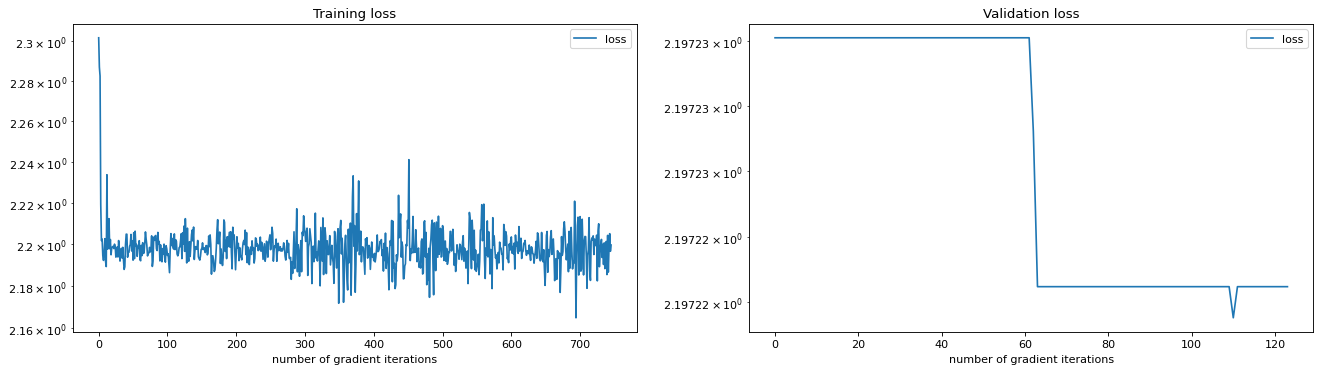

Validation epoch 1, iteration 60 of 63 (95 %), loss=2.1972


In [18]:
# Training and validation with cross entropy loss and Adam optimizer
from torch.utils.data import DataLoader

train_loader = DataLoader(pgm_dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(pgm_dataset_val, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(pgm_dataset_test, batch_size=BATCH_SIZE, shuffle=False)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)

# prepare plotting
fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,2)

# Initialize the ViT model
model = ViT().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8)

# Training loop
num_epochs = 2  # Adjust as needed
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_iter = iter(train_loader)
    model.train()
    # for context_images, choice_images, targets, _, _ in tqdm(train_loader):
    for i in range(len(train_loader)):
        batch_cpu = next(train_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = model(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')

        # Loss calculation, backward pass, and optimization
        loss = criterion(pred['choice_scores'], batch_gpu['target'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Plotting
        if i%5==0:
            axes[0].cla()

            # Plot the training error on a log plot
            axes[0].plot(train_losses, label='loss')
            axes[0].set_yscale('log')
            axes[0].set_title('Training loss')
            axes[0].set_xlabel('number of gradient iterations')
            axes[0].legend()

            # Clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Training epoch {}, iteration {} of {} ({} %), loss={:0.4f}".format(epoch, i, len(train_loader), 100*i//len(train_loader), train_losses[-1]))


    # Validation loop
    val_iter = iter(val_loader)
    model.eval()
    for i in range(len(val_loader)):
        batch_cpu = next(val_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = model(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')

        # Calculate loss
        with torch.no_grad():
            val_loss = 0
            correct = 0
            total = 0

            loss = criterion(pred['choice_scores'], batch_gpu['target'])
            val_losses.append(loss.item())

            # Plotting
            if i%5==0:
                axes[1].cla()

                # Plot the validation error on a log plot
                axes[1].plot(val_losses, label='loss')
                axes[1].set_yscale('log')
                axes[1].set_title('Validation loss')
                axes[1].set_xlabel('number of gradient iterations')
                axes[1].legend()

                # Clear output window and diplay updated figure
                display.clear_output(wait=True)
                display.display(plt.gcf())
                print("Validation epoch {}, iteration {} of {} ({} %), loss={:0.4f}".format(epoch, i, len(val_loader), 100*i//len(val_loader), val_losses[-1]))
plt.close('all')

In [19]:
# Saving the model parameters
MODEL_DIR = "./model/"
MODEL_NAME = "vit_model_2024-11-26_11-18.pth"
torch.save(model.state_dict(), os.path.join(MODEL_DIR, MODEL_NAME))

# Testing

In [20]:
# Loading the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT().to(device)
model.load_state_dict(torch.load(MODEL_DIR+MODEL_NAME, weights_only=True))

<All keys matched successfully>

In [21]:
def get_accuracy(network, data_loader):
    network.eval()
    iterator = iter(data_loader)
    correct = 0
    total = 0
    for i in range(len(iterator)):
        batch_cpu = next(iterator)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)['choice_scores'].argmax(dim=1, keepdim=True)
        correct += pred.eq(batch_gpu['target'].view_as(pred)).sum().item()
        total += pred.shape[0]

    return correct / total

In [22]:
print('train acc:', get_accuracy(model, train_loader))
print('validation acc:', get_accuracy(model, val_loader))
print('test acc:', get_accuracy(model, test_loader))

train acc: 0.11858333333333333
validation acc: 0.139
test acc: 0.1225
